Let's try some Fourier transformation stuff and see if I can find a pattern in the time series data. 

I will be trying FTT based on a couple papers and have my code based on the work of a developer https://github.com/snazrul1


In [1]:
# Importing Libraries 
from pandas_datareader import data
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



Importing the Yahoo Finance Data


In [2]:
ticker ='AAPL'

#Fix the start and the end date
start_date = '1993-01-01'
end_date = '2016-01-01'

Using Yahoo Finance Fix API to load the data

In [3]:
df_original = yf.download(ticker,start_date,end_date)
df_original.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-04,2.125000,2.142857,2.062500,2.080357,0.460625,32284000
1993-01-05,2.071429,2.116071,2.044643,2.116071,0.468532,46564000
1993-01-06,2.169643,2.214286,2.160714,2.205357,0.488302,70350000
1993-01-07,2.205357,2.232143,2.165179,2.178571,0.482371,68034400
1993-01-08,2.169643,2.250000,2.133929,2.223214,0.492256,80234000


In [4]:
print ("Length: ", len(df_original))

Length:  5793


Looking at only the closing time, let's take fist 4000 data for training and rest for test. 

In [5]:
df = df_original[:4000]
df = df[['Adj Close']]
df.head()

,Adj Close
Date,
1993-01-04,0.460625
1993-01-05,0.468532
1993-01-06,0.488302
1993-01-07,0.482371
1993-01-08,0.492256


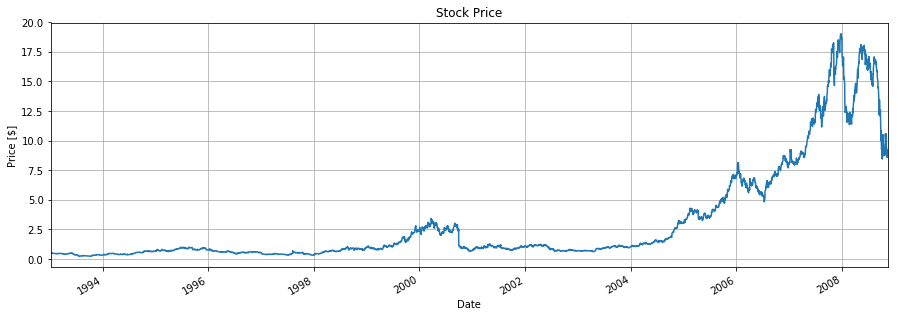

In [6]:
plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.ylabel('Price [$]')
plt.title('Stock Price');

Performing FFT on the change of price over time.

At first add a column to show the change in price. So append a line of data at the top with price = 0. 


In [7]:
df['delta'] = np.append(np.array([0]),
                        np.diff(df['Adj Close'].values))
df['delta'].head()

Date
1993-01-04    0.000000
1993-01-05    0.007907
1993-01-06    0.019770
1993-01-07   -0.005931
1993-01-08    0.009885
Name: delta, dtype: float64

In [8]:
sp = np.fft.fft(df['delta'].values)
sp[:10]

array([  8.135417   +0.j        ,   1.30795115 +9.11933144j,
        -9.16486143+10.11493383j,  -8.66359971 +1.07065638j,
       -12.53894541 +2.83209324j, -10.63864604 +1.70038112j,
       -16.2820675  -2.8982742j ,  -8.37687181 -5.9514555j ,
        -9.12463495-10.6779481j ,  -0.70609076 -4.86595781j])

Calculating theta, amplitude and frequency. 

In [9]:
df['theta'] = np.arctan(sp.imag/sp.real)
numValues = len(df)
numValuesHalf = numValues / 2
df['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
df['freq'] = np.fft.fftfreq(sp.size, d=1)
df.head()

,Adj Close,delta,theta,amplitude,freq
Date,,,,,
1993-01-04,0.460625,0.000000,0.000000,0.004068,0.00000
1993-01-05,0.468532,0.007907,1.428342,0.004606,0.00025
1993-01-06,0.488302,0.019770,-0.834636,0.006825,0.00050
1993-01-07,0.482371,-0.005931,-0.122958,0.004365,0.00075
1993-01-08,0.492256,0.009885,-0.222136,0.006427,0.00100


Using frequency and amplitude to calculate dominant frequency. 

For any Fourier Transform function, we will have a mirror image along the middle (marked in red line).

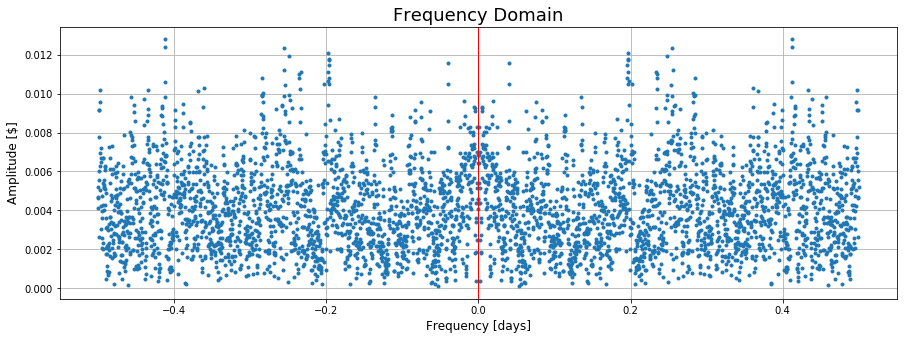

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df['freq'],df['amplitude'].values, '.')
plt.axvline(x=0, ymin=0, ymax = 1, linewidth=1, color='r')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain', fontsize=18)
plt.grid();

Take left half of the image (positive frequency) and filter frequencies w/ amplitude of over 3 standard deviations.

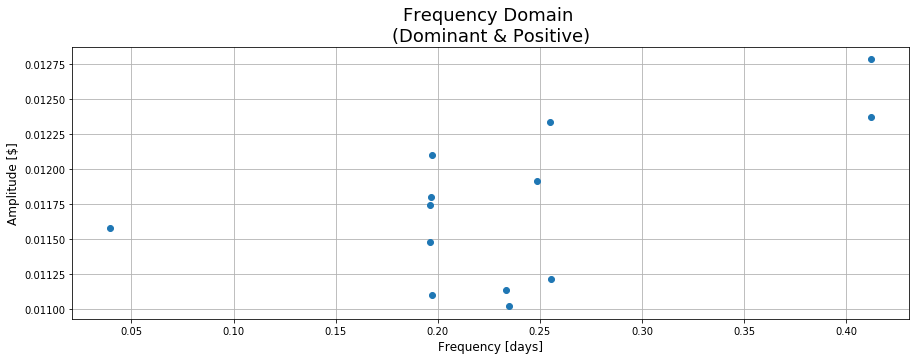

In [11]:
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (3*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid();

Reconstructing the prices using the dominant frequency values.

Since we have been using the time delta, we will perform a cumsum on all the time deltas and add it to the initial adjusting closing stock value to perform a regression.


In [12]:
regressionDelta = 0

for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)


#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

df['regression'] = regression

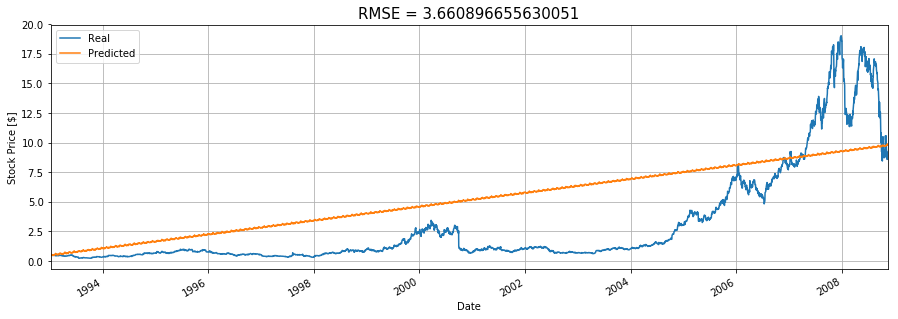

In [13]:
plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.plot(df['regression'])
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted'])

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);


Optimizing the filter value (the standard deviation) to minimize our RMSE.

In [14]:
def std_filter(std_value):
    
    #Getting dominant values based on std_value
    meanAmp = df['amplitude'].mean()
    stdAmp = df['amplitude'].std()
    dominantAmpCheck = df['amplitude'] > (std_value*stdAmp + meanAmp) 
    positiveFreqCheck = df['freq'] > 0
    dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
    dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
    dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']
    
    #Calculating Regression Delta
    regressionDelta = 0
    for n in range(len(dominantTheta)):
        shift = dominantTheta[n]
        regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)

    #Converting Delta Time to Time at start value of real data    
    startValue = df['Adj Close'][0]
    regression = startValue - np.cumsum(regressionDelta)
    
    #Calculating RMSE
    rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))
    
    if np.isnan(rmse):
        rmse = 10000000000000
    
    return rmse

In [15]:
std_values = []
rmse_values = []

for i in np.linspace(0,2,20):
    std_values.append(i)
    rmse_values.append(std_filter(i))

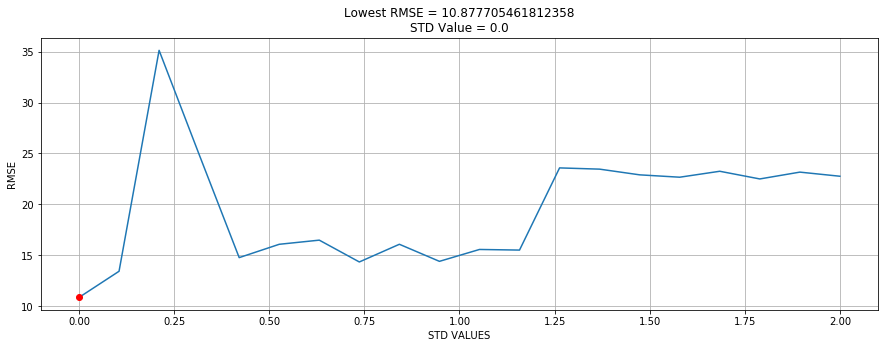

In [16]:
idx = np.array(rmse_values).argmin()
minSTD = std_values[idx]
minRMSE = rmse_values[idx]

plt.figure(figsize=(15,5))
plt.plot(std_values, rmse_values)
plt.plot(minSTD, minRMSE, 'ro')
plt.ylabel('RMSE')
plt.xlabel('STD VALUES')
plt.title('Lowest RMSE = '+str(minRMSE)+'\nSTD Value = '+str(minSTD))
plt.grid()

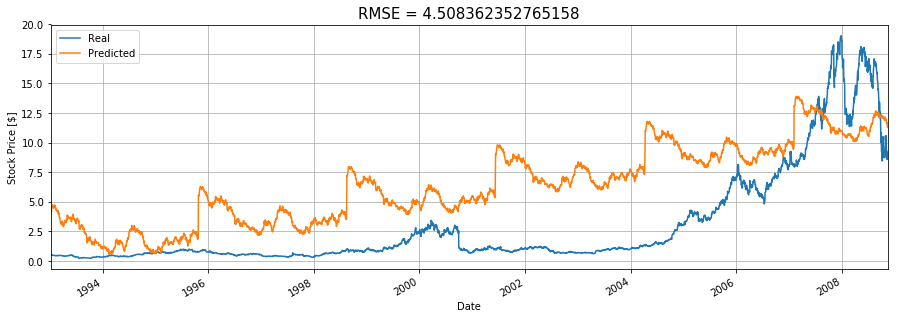

In [20]:
#Getting dominant values based on std_value
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (minSTD*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

df['regression'] = regression

plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.plot(df['regression'])
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

Now let's make the prediciton after the 4000th day (marked by the red line)

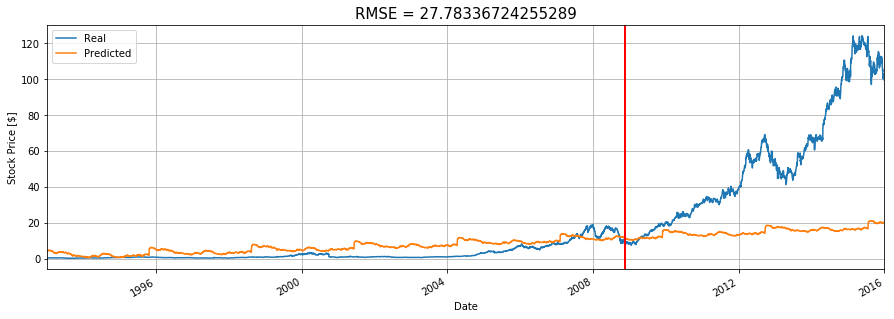

In [18]:
#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df_original))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)
df_original['regression'] = regression

plt.figure(figsize=(15,5))
df_original['Adj Close'].plot(grid=True)
plt.plot(df_original['regression'])
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted'])


plt.axvline(x=df_original.iloc[4001].name, ymin=0, ymax = 1, linewidth=2, color='r')

rmse = np.sqrt(np.mean((df_original['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);
